In [77]:
import numpy as np
import pandas as pd
from urllib2 import Request, urlopen
import json
import sys
from pandas.io.json import json_normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
# import scipy as sp
# from sklearn import preprocessing
# from sklearn import linear_model
from sklearn.cross_validation import KFold, cross_val_score
# from sklearn.linear_model import LogisticRegression
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.linear_model import LogisticRegressionCV as LogRegCV
# from statsmodels.regression.linear_model import OLS
# import sklearn.preprocessing as Preprocessing
# from sklearn.preprocessing import StandardScaler as Standardize
# import itertools as it
# from sklearn.neighbors import KNeighborsClassifier as KNN
# from sklearn.tree import DecisionTreeClassifier as DecisionTree
# from sklearn.ensemble import RandomForestClassifier as RandomForest
# from sklearn.svm import SVC
# from sklearn.cross_validation import train_test_split
# from sklearn import discriminant_analysis
from sklearn import svm
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

In [6]:
# Load dat yung fresh 2015 yelp data
data_2015 = pd.read_json("json_2015.json")
data_2015.head(n=5)

,business_id,cool,date,funny,stars,text,useful,user_id
0,vT12uXtdBQ10_lUcl-M40w,0,2015-01-01,0,1,terrible experience....I am a local first of a...,0,C_xtIn19eKivN335dzjadg
1,aWMxTWSEqBvH2KhdGPLibQ,0,2015-01-01,0,3,Bad service at this location.\n\nGood iced cof...,0,T7J9ae0wTskrI_Bgwp-4cA
2,Z98h1BhssZeFfZvcVTYOpw,0,2015-01-01,0,2,We have been to Maya's many times since it fir...,1,O7WaUuYwX45Ia6Mvf01UCw
3,3rwM9fPYPk9qDkEBOhyHbg,1,2015-01-01,0,5,"booked the hotel for new years, over the phone...",1,kq-4vbC1cHQbRKyDmwERSA
4,JpYn_HdxQNZQSlWWv4P6Iw,0,2015-01-01,0,3,"Good, not great. Not a ton of tea options but ...",1,XweddetOpWNuJQ5mLb_5JQ


In [7]:
# Create a dataset using only 1400 of those reviews
rand_1400 = data_2015.sample(frac=.0021)
rand_1400.head()

,business_id,cool,date,funny,stars,text,useful,user_id
263036,Cpjt0CxAEmVSgUVsaB30DA,1,2015-06-01,1,5,This was a great experience. They services me ...,1,hyK09yFvmb0nhyWv2tY-Hw
155976,nvIAR-a_39UF05eYHvoGOQ,0,2015-04-02,0,4,Very cute bookshop in the northern part of the...,1,a0pDNquwLGS-PCeqjL-umg
4902,y2FMWeHfbxQADvcdV2ja2w,0,2015-01-03,0,4,I love the ambiance in this place. The hardwoo...,0,WE61REQMkSo-cwFGawkBag
194508,i8EcaWDkkfo3T3d5APfzsQ,0,2015-04-24,0,4,"YUM! I got the eggs florentine, boyfriend got ...",0,1U1fnEd_XrxVLPXyXWRgyQ
260039,1n-GvDcbst4BAInt-f0JBQ,0,2015-05-31,0,5,If I could give Belleza Wedding Chapel a milli...,0,i3DsMWuNYlZUZr7I21VXMQ


In [8]:
'The original set has {0} entries, while our testing set only has {1}.'.format(data_2015.shape[0], rand_1400.shape[0])

'The original set has 666815 entries, while our testing set only has 1400.'

Range of Review Lengths: 2 words - 952 words
Mean of Review Lengths: 104.177857143


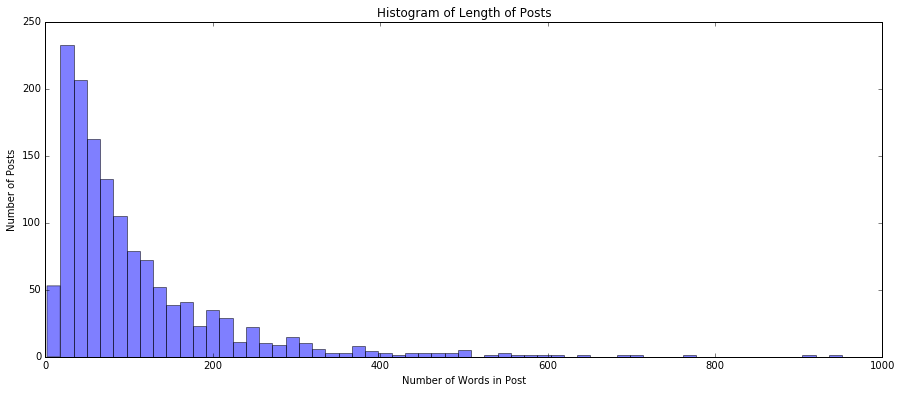

In [9]:
# Splits each review by spaces.
lengths = rand_1400['text'].apply(lambda x: len(x.split(' ')))

print 'Range of Review Lengths: {0} words - {1} words'.format(np.min(lengths), np.max(lengths))
print 'Mean of Review Lengths: {}'.format(np.mean(lengths))

fig, ax = plt.subplots(1, 1, figsize=(15, 6))

# Histogram of the word counts in each post
ax.hist(lengths, color='blue', bins=60, alpha=0.5)

ax.set_xlabel('Number of Words in Post')
ax.set_ylabel('Number of Posts')
ax.set_title('Histogram of Length of Posts')

plt.show()

In [10]:
# Create a text vectorizer (turns text into array of numbers)
vectorizer = CountVectorizer(stop_words='english', min_df=1, binary=True)

# Get all the text from data
corpus = rand_1400['text'].values

# Turn each text into an array of word counts
x = vectorizer.fit_transform(corpus)
x = x.toarray()

# Get the names of all the words we're counting
feature_names = vectorizer.get_feature_names()

#Number of top words
n = 20

#Count the number of time each word occurs in the entire dataset
word_freq = x.sum(axis=0)

#Sort the words by their total frequency in the dataset
words = zip(word_freq, feature_names)
top_words = (sorted(words, key=lambda t: t[0], reverse=True))[:n]

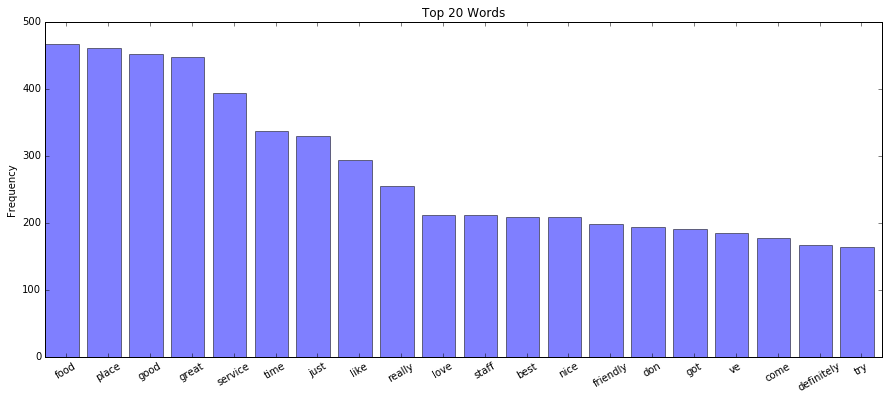

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))

# Number of bars to use
indices = np.arange(n)
# Where to put the label under each bar
width = 0.5
# Bar plot of the frequencies of the top words
ax.bar(indices, [word[0] for word in top_words], color='blue', alpha=0.5)

ax.set_ylabel('Frequency')
ax.set_title('Top ' + str(n) + ' Words')

# Label the bars with the top words
ax.set_xticks(indices + width)
ax.set_xticklabels([word[1] for word in top_words])

# Turn the labels sideways so they don't overlap
labels = ax.get_xticklabels()
plt.setp(labels, rotation=30, fontsize=10)

plt.show()

In [12]:
# Encode the class labels, things sometimes get funky if you don't do this.
labels = rand_1400['stars'].values
enc_label = LabelEncoder()
y = enc_label.fit_transform(labels)

# Adjust from 0 to 4, to 1 to 5.
y = y + 1

In [13]:
# Print the number of comments in each class
print 'Number of 1 star posts:', len(y[y == 1])
print 'Number of 2 star posts:', len(y[y == 2])
print 'Number of 3 star posts:', len(y[y == 3])
print 'Number of 4 star posts:', len(y[y == 4])
print 'Number of 5 star posts:', len(y[y == 5])

Number of 1 star posts: 222
Number of 2 star posts: 94
Number of 3 star posts: 135
Number of 4 star posts: 297
Number of 5 star posts: 652


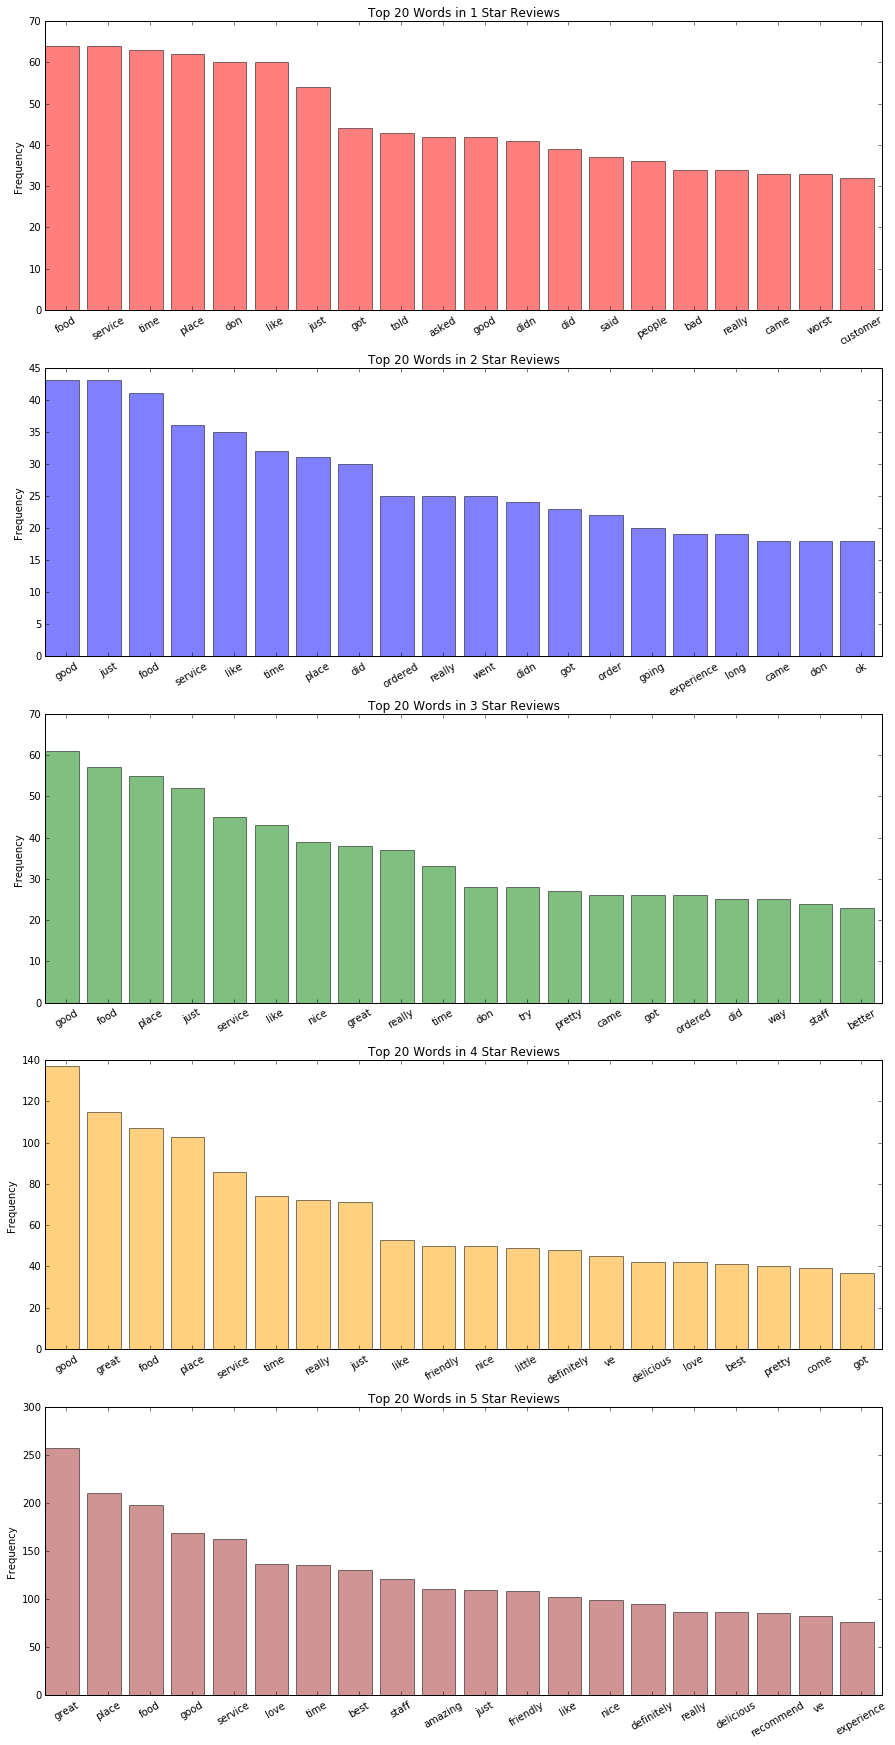

In [14]:
colors = ["red", "blue", "green", "orange", "brown"]
fig, ax = plt.subplots(5, 1, figsize=(15, 30))

for i in range(5):
    #Number of bars to use
    indices = np.arange(n)
    #Where to put the label under each bar
    width = 0.5

    #Count the number of time each word occurs in the 1 stars posts
    word_freq = x[y == i+1].sum(axis=0)

    #Sort the words by their total frequency in the dataset
    words = zip(word_freq, feature_names)
    top_words = (sorted(words, key=lambda t: t[0], reverse=True))[:n]

    #Bar plot of the frequencies of the top words
    ax[i].bar(indices, [word[0] for word in top_words], color=colors[i], alpha=0.5)

    ax[i].set_ylabel('Frequency')
    ax[i].set_title('Top ' + str(n) + ' Words in ' + str(i+1) + ' Star Reviews')

    #Label the bars with the top words
    ax[i].set_xticks(indices + width)
    ax[i].set_xticklabels([word[1] for word in top_words])

    #Turn the labels sideways so they don't overlap
    labels = ax[i].get_xticklabels()
    plt.setp(labels, rotation=30, fontsize=10)

plt.show()

In [15]:
# Train/test split
n_samples = len(x)
train_indices = np.random.uniform(size=n_samples) > 1. / 3.  #Select two thirds for train

x_train = x[train_indices]
y_train = y[train_indices]
print "Reviews in Training Set: {0}".format(x_train.shape[0])
x_test = x[~train_indices]
y_test = y[~train_indices]

#Generate array of L2 regularization parameters
regularization = 10.**np.arange(-10, 5)

#Fit logistic model with cross validation to select the optimal regularization parameter
logistic = LogRegCV(cv=5, penalty='l2', Cs=regularization, solver='liblinear', n_jobs=4)
logistic.fit(x_train, y_train)

#Print results
print 'Accuracy on overall test set:', logistic.score(x_test, y_test)
print 'Accuracy on 1 star in test set:', logistic.score(x_test[y_test == 1], y_test[y_test == 1])
print 'Accuracy on 2 star in test set:', logistic.score(x_test[y_test == 2], y_test[y_test == 2])
print 'Accuracy on 3 star in test set:', logistic.score(x_test[y_test == 3], y_test[y_test == 3])
print 'Accuracy on 4 star in test set:', logistic.score(x_test[y_test == 4], y_test[y_test == 4])
print 'Accuracy on 5 star in test set:', logistic.score(x_test[y_test == 5], y_test[y_test == 5])

Reviews in Training Set: 943
Accuracy on overall test set: 0.490153172867
Accuracy on 1 star in test set: 0.553846153846
Accuracy on 2 star in test set: 0.0
Accuracy on 3 star in test set: 0.707317073171
Accuracy on 4 star in test set: 0.0291262135922
Accuracy on 5 star in test set: 0.728971962617


In [16]:
# This function computes the accuracy of logistic regression given cut-offs, min_df, max_df
def vectorize_classify(min_df, max_df, trials, x, y):
    #Create a text vectorizer, removing words with frequency less than min_df or
    #greater than max_df
    vectorizer = CountVectorizer(stop_words='english', min_df=min_df, max_df=max_df)
    #Transform our text into arrays of numbers
    corpus = rand_1400['text'].values
    x = vectorizer.fit_transform(corpus)
    x = x.toarray()
    
    #Record overall accuracy rate, accuracy on class 1 and class 0
    overall_acc = []
    class_5_acc = []
    class_4_acc = []
    class_3_acc = []
    class_2_acc = []
    class_1_acc = []
    
    
    n_samples = len(x)
    
    #Perform logistic regression on a handful of train/test splits
    for i in range(trials):
        #Print progress
        sys.stdout.write("\r{0}% completed".format((float(i + 1)/trials)*100))
        sys.stdout.flush()
        
        # Train/test split
        train_indices = np.random.uniform(size=n_samples) > 1. / 3.  #Select two thirds for train

        x_train = x[train_indices]
        y_train = y[train_indices]

        x_test = x[~train_indices]
        y_test = y[~train_indices]

        #Generate array of L2 regularization parameters
        regularization = 10. ** np.arange(-10, 5)

        #Fit logistic model
        logistic = LogRegCV(cv=5, 
                            penalty='l2', 
                            Cs=regularization, 
                            solver='liblinear', 
                            n_jobs=4)
        logistic.fit(x_train, y_train)
        
        overall_acc.append(logistic.score(x_test, y_test))
        class_1_acc.append(logistic.score(x_test[y_test == 1], y_test[y_test == 1]))
        class_2_acc.append(logistic.score(x_test[y_test == 2], y_test[y_test == 2]))
        class_3_acc.append(logistic.score(x_test[y_test == 3], y_test[y_test == 3]))
        class_4_acc.append(logistic.score(x_test[y_test == 4], y_test[y_test == 4]))
        class_5_acc.append(logistic.score(x_test[y_test == 5], y_test[y_test == 5]))

    return (np.mean(overall_acc), 
            np.mean(class_1_acc),
            np.mean(class_2_acc),
            np.mean(class_3_acc),
            np.mean(class_4_acc),
            np.mean(class_5_acc))

In [17]:
# Solution to not identifying class 2 and 3 possibly
min_df = 15
max_df = 180
trials = 10
overall, class_1, class_2, class_3, class_4, class_5 = vectorize_classify(min_df, max_df, trials, x, y)
print '\nMin frequency, max frequency:', min_df, ',', max_df
print 'Accuracy on overall test set:', overall
print 'Accuracy on class 1 in test set:', class_1
print 'Accuracy on class 2 in test set:', class_2
print 'Accuracy on class 3 in test set:', class_3
print 'Accuracy on class 4 in test set:', class_4
print 'Accuracy on class 5 in test set:', class_5

100.0% completed
Min frequency, max frequency: 15 , 180
Accuracy on overall test set: 0.496212805266
Accuracy on class 1 in test set: 0.351138565467
Accuracy on class 2 in test set: 0.0978105228105
Accuracy on class 3 in test set: 0.121463328942
Accuracy on class 4 in test set: 0.445508342554
Accuracy on class 5 in test set: 0.708930202422


In [85]:
pca = PCA(n_components=800)
pca.fit(x_train)
x_reduced = pca.transform(x)
x_train_red = pca.transform(x_train)

x_1 = x_reduced[y==1, :]
x_2 = x_reduced[y==2, :]
x_3 = x_reduced[y==3, :]
x_4 = x_reduced[y==4, :]
x_5 = x_reduced[y==5, :]

logistic.fit(x_train_red, y_train)

y_pred = logistic.predict(x_reduced)
pred_1 = logistic.predict(x_1)
pred_2 = logistic.predict(x_2)
pred_3 = logistic.predict(x_3)
pred_4 = logistic.predict(x_4)
pred_5 = logistic.predict(x_5)

print 'Accuracy for reviews:', np.mean(y == y_pred)
print 'Accuracy for 1 star:', np.mean(y[y==1] == pred_1)
print 'Accuracy for 2 Star:', np.mean(y[y==2] == pred_2)
print 'Accuracy for 3 Star:', np.mean(y[y==3] == pred_3)
print 'Accuracy for 4 Star:', np.mean(y[y==4] == pred_4)
print 'Accuracy for 5 Star:', np.mean(y[y==5] == pred_5)

Accuracy for reviews: 0.735
Accuracy for 1 star: 0.851351351351
Accuracy for 2 Star: 0.404255319149
Accuracy for 3 Star: 0.874074074074
Accuracy for 4 Star: 0.367003367003
Accuracy for 5 Star: 0.881901840491


In [86]:
binary_y = [] #class observations according to whether they have at least one "helpful" vote

for score in rand_1400.useful.values:
    i = 1 if score > 0 else 0
    binary_y.append(i)
binary_y = np.array(binary_y)
# Train/test split
train_indices = np.random.uniform(size=len(x)) > 1. / 3.  #Select two thirds for train

x_bi_train = x[train_indices]
y_bi_train = binary_y[train_indices]

x_bi_test = x[~train_indices]
y_bi_test = binary_y[~train_indices]

pca = PCA(n_components=900)
pca.fit(x_bi_train)
x_bi_reduced = pca.transform(x)
x_bi_train_red = pca.transform(x_bi_train)


In [87]:
x_bi_test_red = pca.transform(x_bi_test)
print x_bi_test.shape
print y_bi_test.shape
print x_bi_test_red.shape
logistic.fit(x_bi_train_red, y_bi_train)
y_bi_test_pred = logistic.predict(x_bi_test_red)
print np.mean(y_bi_test_pred==y_bi_test)

(467, 9678)
(467,)
(467, 900)
0.665952890792


C= 0.0001 : 0.657153687197
C= 0.001 : 0.657156744067
C= 0.01 : 0.647163836005
C= 0.1 : 0.640007703312
C= 1 : 0.612147390044
C= 10 : 0.586399373953
C= 100 : 0.57282381424


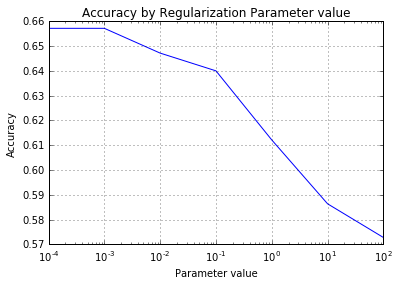

In [88]:
cvals = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
scores = []
for c in cvals: #try cross validating the data with different regularization parameters
    log_model = LogReg(C=c, penalty='l2') #initiate unregularized logistic regression model
    score = cross_val_score(log_model, x_bi_reduced, binary_y, n_jobs=-1).mean() #cross validate
    scores.append(score)
    print "C=",c ,":", score
    
plt.plot(cvals, scores)
plt.xscale('log')
plt.title("Accuracy by Regularization Parameter value")
plt.xlabel("Parameter value")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

In [89]:
model = svm.SVC(kernel='poly', gamma=2, C=100)
model.fit(x_bi_train_red, list(y_bi_train))
print model.score(x_bi_test_red, list(y_bi_test))

0.638115631692


In [90]:
print '5-fold cross validation:'
best_score = 0
k_folds = KFold(x_bi_train_red.shape[0], n_folds=5, shuffle=True)
scores = []
trainers = [None, None]
for train_indices, validation_indices in k_folds:
    # Generate training data
    x_train_cv = x_bi_train_red[train_indices]
    y_train_cv = y_bi_train[train_indices]
    # Generate validation data
    x_validate = x_bi_train_red[validation_indices]
    y_validate = y_bi_train[validation_indices]

    # Fit random forest on training data
    model = svm.SVC(kernel='poly', gamma=2, C=100)
    model.fit(x_train_cv, list(y_train_cv))
    if model.score(x_validate, list(y_validate)) > best_score:
        trainers[0] = x_train_cv
        trainers[1] = y_train_cv
    scores += [model.score(x_validate, list(y_validate))]

average_score = np.mean(scores)
print "Kernel:", 'rbf', "Gamma:", 2, "C:", 100, "Average score:", average_score

model = svm.SVC(kernel='poly', gamma=2, C=100)
model.fit(trainers[0], list(trainers[1]))
print model.score(x_bi_test_red, list(y_bi_test))

5-fold cross validation:
Kernel: rbf Gamma: 2 C: 100 Average score: 0.636656891496
0.646680942184


In [91]:
# Parameters for tuning
n_trees = np.arange(10, 100, 20)  # Trees and depth are explored on an exponentially growing space,
depths = np.arange(2, 10)   # since it is assumed that trees and depth will add accuracy in a decaying fashion.

# To keep track of the best model
best_score = 0

# Run grid search for model with 5-fold cross validation
print '5-fold cross validation:'

for trees in n_trees:
    for depth in depths:
        
        # Cross validation for every experiment
        k_folds = KFold(x_bi_train_red.shape[0], n_folds=5, shuffle=True)
        scores = []
        for train_indices, validation_indices in k_folds:
            # Generate training data
            x_train_cv = x_bi_train_red[train_indices]
            y_train_cv = y_bi_train[train_indices]
            # Generate validation data
            x_validate = x_bi_train_red[validation_indices]
            y_validate = y_bi_train[validation_indices]      
            
            # Fit random forest on training data
            model = RandomForestClassifier(n_estimators=trees, max_depth=depth)
            model.fit(x_train_cv, y_train_cv)
            # Score on validation data
            scores += [model.score(x_validate, y_validate)]
        
        # Record and report accuracy
        average_score = np.mean(scores)
        print "Trees:", trees, "Depth:", depth, "Score:", average_score
        
        # Update our record of the best parameters see so far
        if average_score > best_score:
            best_score = average_score
            best_trees = trees
            best_depth = depth

# Fit model on entire train set using chosen number of trees and depth
model = RandomForestClassifier(n_estimators=best_trees, max_depth=best_depth)
model.fit(x_bi_train_red, y_bi_train)

print 'Chosen number of trees, depth:', best_trees, ',', best_depth
print 'Test accuracy:', model.score(x_bi_test_red, y_bi_test)

5-fold cross validation:
Trees: 10 Depth: 2 Score: 0.630211028693
Trees: 10 Depth: 3 Score: 0.647288827554
Trees: 10 Depth: 4 Score: 0.647375079064
Trees: 10 Depth: 5 Score: 0.62156287735
Trees: 10 Depth: 6 Score: 0.631309297913
Trees: 10 Depth: 7 Score: 0.613052728423
Trees: 10 Depth: 8 Score: 0.607722385142
Trees: 10 Depth: 9 Score: 0.618417572308
Trees: 30 Depth: 2 Score: 0.630308780404
Trees: 30 Depth: 3 Score: 0.639882697947
Trees: 30 Depth: 4 Score: 0.633419584843
Trees: 30 Depth: 5 Score: 0.629222011385
Trees: 30 Depth: 6 Score: 0.635616123282
Trees: 30 Depth: 7 Score: 0.639842447243
Trees: 30 Depth: 8 Score: 0.633477085849
Trees: 30 Depth: 9 Score: 0.644178023115
Trees: 50 Depth: 2 Score: 0.631234546605
Trees: 50 Depth: 3 Score: 0.646259559542
Trees: 50 Depth: 4 Score: 0.647403829567
Trees: 50 Depth: 5 Score: 0.655919728595
Trees: 50 Depth: 6 Score: 0.650623885918
Trees: 50 Depth: 7 Score: 0.644143522512
Trees: 50 Depth: 8 Score: 0.64523029153
Trees: 50 Depth: 9 Score: 0.650572

In [92]:
float(binary_y[binary_y == 0].shape[0]) / binary_y.shape[0]

0.6264285714285714

Naive Bayes Classifier... Needs More Work

In [93]:
text_clf = Pipeline([('vect', CountVectorizer(stop_words='english', min_df=1, binary=True)), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB()),])
text_clf = text_clf.fit(rand_1400['text'].values, rand_1400['stars'].values)
predicted = text_clf.predict(rand_1400['text'].values)
print np.mean(predicted==rand_1400['stars'].values)

0.508571428571


In [94]:
parameters = {'vect__ngram_range': [(1, 1), (1, 2)], 'tfidf__use_idf': (True, False), 'clf__alpha': (1e-2, 1e-3),}
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(rand_1400['text'].values, rand_1400['stars'].values)
cv_predicted = gs_clf.predict(rand_1400['text'].values)
print np.mean(predicted==rand_1400['stars'].values)

0.508571428571
